# 📡 Имитационное моделирование RFID системы в зависимости от параметра `Q` и количества меток в зоне чтения

В данном блокноте проводится имитацинное моделирование RFID системы для изучения зависимости вероятности чтения банка памяти `USER` от параметра, количества меток в зоне чтения, количества коллизий. Также изучается работа команды QueryAdjust и алгоритма коррекции `Q`

### Импорт необходимых модулей

In [1]:
import numpy as np

from pysim.experiments.utility.sim_helper import generation_interval
from pysim.experiments.utility.rfid_sim import calculate_probs, plot_probs
from pysim.models.rfid.params import default_params, inner_params

In [2]:
IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "results/result_jsons/rfid/multiple_tag/"

### ⚙️ Общие параметры для разных кривых

In [3]:
q_variable = np.arange(0, 16, 1)
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

q_params_list = []
for coding_params_item in coding_params:
    q_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
         # 'num_tags': default_params.num_tags,
        'num_tags': 10,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
    })

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае без коллизий и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

Как хорошо видно из результатов, при небольших значениях `Q` разницы в величине вероятности почти нет. Начиная с Q = 7 вероятность чтения начинает стремительно уменьшаться из-за того, что раунд заполняется пустыми слотами и становится слишком длинным. В результате этого метка успевает принять участие в меньшем количестве раундов инвентаризации и вероятность снижается.

### 💾 Получение результатов

In [4]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [5]:
q_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    use_json=False,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q.json"
)
# Моделирование на M3 Pro с 'num_tags': 200:
# Моделирование по переменной q: 100%|██████████| 5/5 [02:37<00:00, 31.41s/it]

Моделирование по переменной q:  20%|██        | 1/5 [00:04<00:16,  4.07s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  40%|████      | 2/5 [00:06<00:08,  2.82s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  60%|██████    | 3/5 [00:08<00:04,  2.47s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  80%|████████  | 4/5 [00:11<00:02,  2.65s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M4, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M4, Tari = 6.25 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M8, Tari = 25.0 мкс': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


### 🖼️ Построение графика

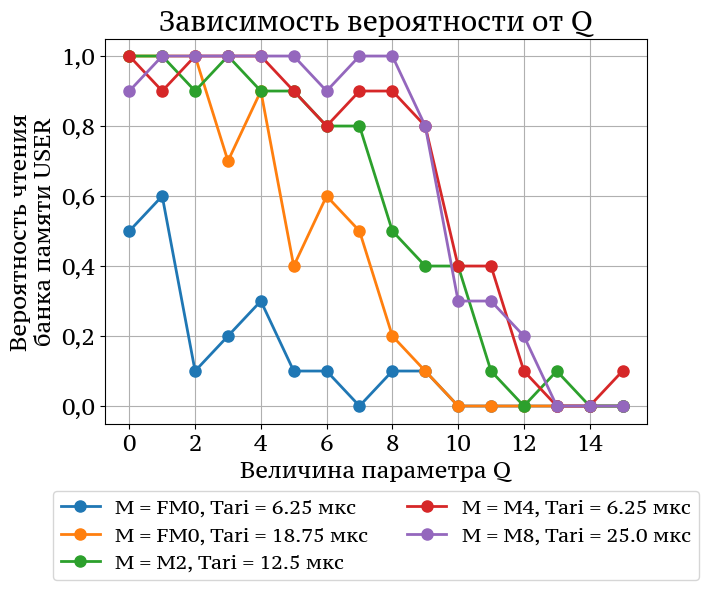

In [6]:
plot_probs(
    results_list=[q_result],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость вероятности от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Q probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае **с коллизиями** и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

In [7]:
additional_params = {
    "generation_interval": (generation_interval,)
}

### 💾 Получение результатов

In [8]:
q_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    additional_params = additional_params,
    use_json=False,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision.json"
)
# Моделирование на M3 Pro с 'num_tags': 200:
# Моделирование по переменной q: 100%|██████████| 5/5 [02:11<00:00, 26.29s/it]

Моделирование по переменной q:  20%|██        | 1/5 [00:02<00:09,  2.29s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [919.2, 397.5, 81.2, 27.4, 8.8, 3.8, 0.8, 1.4, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  40%|████      | 2/5 [00:03<00:04,  1.64s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [919.2, 397.5, 81.2, 27.4, 8.8, 3.8, 0.8, 1.4, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [315.6, 125.0, 12.2, 4.8, 2.6, 1.5, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  60%|██████    | 3/5 [00:04<00:02,  1.46s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [919.2, 397.5, 81.2, 27.4, 8.8, 3.8, 0.8, 1.4, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [315.6, 125.0, 12.2, 4.8, 2.6, 1.5, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [337.7, 129.4, 9.9, 4.2, 1.8, 0.6, 0.6, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q:  80%|████████  | 4/5 [00:06<00:01,  1.52s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [919.2, 397.5, 81.2, 27.4, 8.8, 3.8, 0.8, 1.4, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [315.6, 125.0, 12.2, 4.8, 2.6, 1.5, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [337.7, 129.4, 9.9, 4.2, 1.8, 0.6, 0.6, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M4, Tari = 6.25 мкс': [498.7, 218.2, 14.7, 4.8, 2.3, 0.8, 0.4, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Моделирование по переменной q: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

Collisions: {'M = FM0, Tari = 6.25 мкс': [919.2, 397.5, 81.2, 27.4, 8.8, 3.8, 0.8, 1.4, 0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = FM0, Tari = 18.75 мкс': [315.6, 125.0, 12.2, 4.8, 2.6, 1.5, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M2, Tari = 12.5 мкс': [337.7, 129.4, 9.9, 4.2, 1.8, 0.6, 0.6, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M4, Tari = 6.25 мкс': [498.7, 218.2, 14.7, 4.8, 2.3, 0.8, 0.4, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'M = M8, Tari = 25.0 мкс': [57.6, 27.7, 1.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


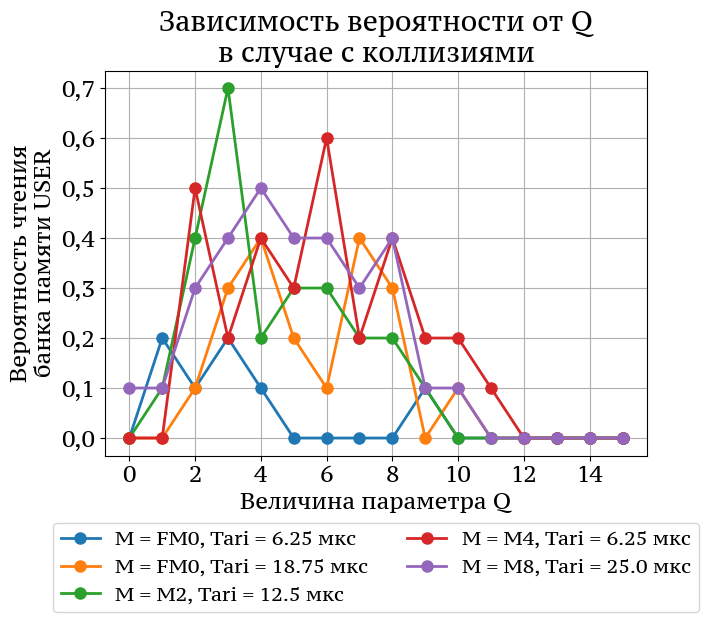

In [9]:
plot_probs(
    results_list=[q_result],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость вероятности от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Collision probs",
    save_fig=False,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)